## Credit Classifier

## Passo 1. Setup do projeto

In [16]:
import joblib
import os
import urllib

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, classification_report

print('Matplot version : {}'.format(matplotlib.__version__))
print('Numpy version : {}'.format(np.__version__))
print('Pandas version : {}'.format(pd.__version__))
print('Sklearn version : {}'.format(sklearn.__version__))

# pacotes incluidos.
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

CREDIT_ROOT = 'http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/'
CREDIT_URL  = CREDIT_ROOT + 'crx.data'

DATA_PATH = os.path.join('..', 'data', 'raw')
DATA_FILE = 'wine.csv'
CREDIT_DATA = os.path.join(DATA_PATH, DATA_FILE)

Matplot version : 3.3.2
Numpy version : 1.19.2
Pandas version : 1.1.3
Sklearn version : 0.23.2


## Passo 2. Recuperação dos dados

In [2]:
def download_data(data_url, data_path, data_file):
    os.makedirs(data_path, exist_ok=True)
    local_path = os.path.join(data_path, data_file)
    urllib.request.urlretrieve(data_url, local_path)

download_data(CREDIT_URL, DATA_PATH, DATA_FILE)

def load_data(data_path, data_file):
    local_path = os.path.join(data_path, data_file)
    return pd.read_csv(local_path, header=None, names=['A1', 'A2', 'A3', 
                                                        'A4', 'A5', 'A6',
                                                        'A7', 'A8', 'A9',
                                                        'A10', 'A11', 'A12', 'A13',
                                                        'A14', 'A15', 'A16'])
credit_data = load_data(DATA_PATH, DATA_FILE)

## Passo 3. Análise Exploratória de Dados

In [3]:
nRow, nCol = credit_data.shape
print(f'Existe um total de {nRow} linhas e {nCol} colunas')

Existe um total de 690 linhas e 16 colunas


In [4]:
credit_data.head(5)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [5]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      690 non-null    object 
 1   A2      690 non-null    object 
 2   A3      690 non-null    float64
 3   A4      690 non-null    object 
 4   A5      690 non-null    object 
 5   A6      690 non-null    object 
 6   A7      690 non-null    object 
 7   A8      690 non-null    float64
 8   A9      690 non-null    object 
 9   A10     690 non-null    object 
 10  A11     690 non-null    int64  
 11  A12     690 non-null    object 
 12  A13     690 non-null    object 
 13  A14     690 non-null    object 
 14  A15     690 non-null    int64  
 15  A16     690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


In [6]:
# Verifica por dados ausentes
credit_data.isnull().sum()

A1     0
A2     0
A3     0
A4     0
A5     0
A6     0
A7     0
A8     0
A9     0
A10    0
A11    0
A12    0
A13    0
A14    0
A15    0
A16    0
dtype: int64

## Passo 4. Preparação de dados

In [7]:
# Troca os '?' por NaN
credit_data = credit_data.replace('?', np.NaN)

# Imputa os valores ausentes com a média
credit_data.fillna(credit_data.mean(), inplace=True)

# Verifica por dados ausentes
credit_data.isnull().sum()

A1     12
A2     12
A3      0
A4      6
A5      6
A6      9
A7      9
A8      0
A9      0
A10     0
A11     0
A12     0
A13     0
A14    13
A15     0
A16     0
dtype: int64

In [8]:
# Percorre cada coluna de credit_data
for col in credit_data.columns:
    # Verifica se a coluna tem o tipo object
    if credit_data[col].dtype == 'object':
        # Coloca o valor mais frequente
        credit_data = credit_data.fillna(0)

# Verifica por dados ausentes
credit_data.isnull().sum()

A1     0
A2     0
A3     0
A4     0
A5     0
A6     0
A7     0
A8     0
A9     0
A10    0
A11    0
A12    0
A13    0
A14    0
A15    0
A16    0
dtype: int64

In [9]:

credit_data["A16"].value_counts()

-    383
+    307
Name: A16, dtype: int64

## Passo 5. Transformação de dados

In [10]:
credit_data["A2"].value_counts()


0        12
22.67     9
20.42     7
24.50     6
19.17     6
         ..
58.42     1
18.67     1
48.25     1
54.83     1
32.83     1
Name: A2, Length: 350, dtype: int64

In [11]:
credit_data["A2"].value_counts()

credit_data['A2'] = credit_data['A2'].astype('float')
credit_data['A14'] = credit_data['A14'].astype('float')

X = credit_data[['A2', 'A3', 'A8', 'A11', 'A14', 'A15']]

for index in credit_data.index:
    if credit_data.loc[index, 'A16'] == '+':
        credit_data.loc[index, 'A16'] = 1
    else:
        credit_data.loc[index, 'A16'] = 0

credit_data['A16'] = credit_data['A16'].astype('int')

y = credit_data['A16']

## Passo 6. Particionamento do dataset

In [12]:
y.value_counts()

0    383
1    307
Name: A16, dtype: int64

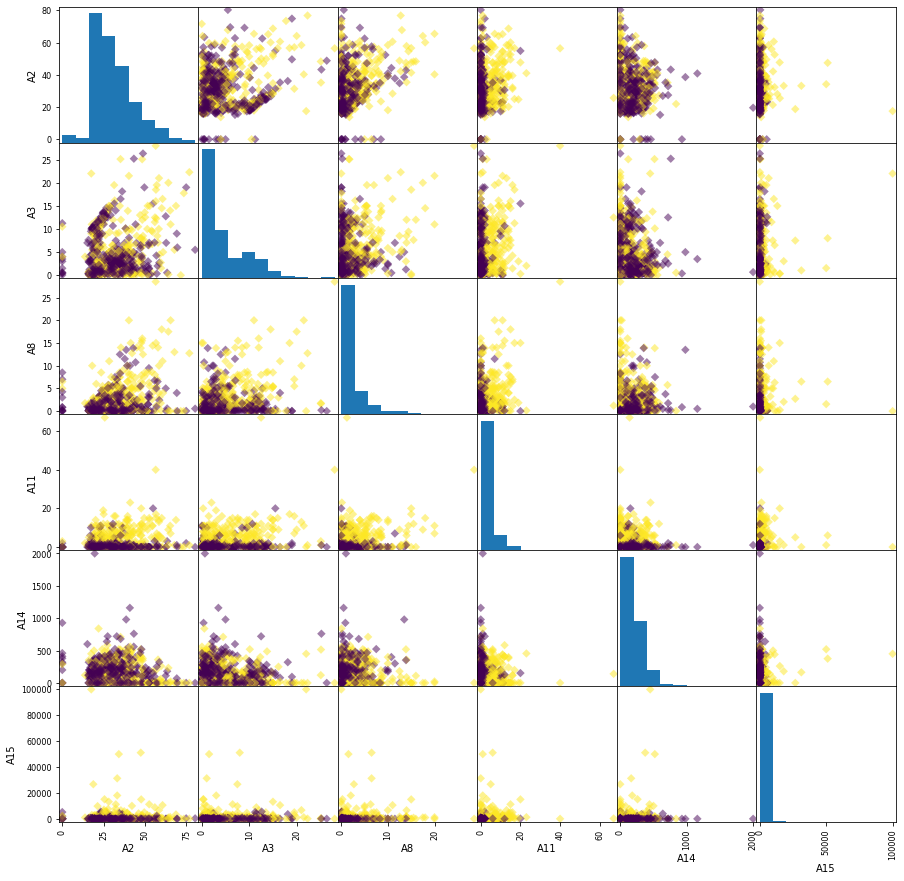

In [13]:
X.replace(np.NaN, 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=42)

_ = pd.plotting.scatter_matrix(X, c=y, figsize=[15,15], marker='D')

In [14]:
def build_classifiers():
    """Retorna uma lista com os classificadores que serão avaliados"""
    
    classifiers=[]
    classifiers.append(
        ('knn',                  # nome do classificador.
         KNeighborsClassifier(), # instancia do classificador.
         {'n_neighbors': range(1, 33, 2)} # hyperparametros.
        )
    )
    
    classifiers.append(
        ('lr',                  # nome do classificador.
         LogisticRegression(max_iter=1000), # instancia do classificador.
         {'penalty': ['l2'], 'C': [100, 10, 1, 0.1, 0.01]} # hyperparametros.
        )
    )
    
    # Algoritmo comentado por conta de demora na execução
    # classifiers.append(
    #    ('svm',                  # nome do classificador.
    #     SVC(), # instancia do classificador.
    #     {'kernel': ['linear', 'rbf'], 
    #      'C': [2**(-5), 1, 2**5, 2**10],
    #      'gamma': [2**(-15), 2**(-10), 2**(-5), 1, 2**5]
    #     } # hyperparametros.
    #    )
    # )
    
    classifiers.append(
        ('dt',                  # nome do classificador.
         DecisionTreeClassifier(), # instancia do classificador.
         {'max_depth': [2, 4, 6, 8, 10, 12]} # hyperparametros.
        )
    )
    
    classifiers.append(
        ('rf',                  # nome do classificador.
         RandomForestClassifier(), # instancia do classificador.
         {'n_estimators': [10, 50, 100]} # hyperparametros.
        )
    )
    
    # Novo algoritmo 
    classifiers.append(
        ('gnb', # nome do classificador.
        GaussianNB(), # instancia do classificador.
        {
        'var_smoothing': [0.00000001, 0.000000001, 0.00000001] # hyperparametros.
        })
    ) 

    return classifiers

In [17]:
classifiers = build_classifiers()
results = []
names   = []

for name, model, parameters in classifiers:
    print('>> classifier name: {}'.format(name))
    gs = GridSearchCV(estimator=model, param_grid=parameters, refit=True, verbose=0)
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    cv = cross_val_score(gs, X_train, y_train, cv=kfold, scoring='accuracy')
    print('Mean: {}, Standard Deviation: {}'.format(cv.mean(), cv.std()))
    results.append(cv)
    names.append(name)

>> classifier name: knn
Mean: 0.6627551020408163, Standard Deviation: 0.07424224233232413
>> classifier name: lr
Mean: 0.7556122448979592, Standard Deviation: 0.06489850289993147
>> classifier name: dt
Mean: 0.7201955782312924, Standard Deviation: 0.06162984962031986
>> classifier name: rf
Mean: 0.7803996598639455, Standard Deviation: 0.03572048557297564
>> classifier name: gnb
Mean: 0.7039540816326532, Standard Deviation: 0.0740892362284532


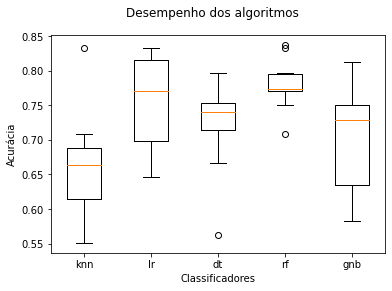

In [18]:
fig, ax = plt.subplots()
fig.suptitle('Desempenho dos algoritmos')
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel('Acurácia')
ax.set_xlabel('Classificadores')
plt.show()

## Passo 7. Conclusão

Foi adicionado ao conjunto de algoritmos de classificação o "Gaussian Naive Bayes".
O melhor algoritmo encontrado para classificação foi o "Logistic Regression", que apresentou a melhor
acurácia.